In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Question Answering with Generative Models on Vertex AI


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/metrics_based_gemini_evaluation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2evaluation%2Fmetrics_based_gemini_evaluation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/evaluation/metrics_based_gemini_evaluation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/evaluation/metrics_based_gemini_evaluation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Nishant Welpulwar](https://github.com/Nish2288)|

##Overview

Generative models like Gemini are powerful language models used for various natural language processing (NLP) tasks like Text classification, Summarization, Question answering and Text Generation.
Evaluating Large Language Models (LLMs) is crucial to assess their capabilities and limitations. You will learn how to evaluate Gemini model by using different metrics.

The type of metrics used for evaluation depends on the task that you are evaluating. The following table shows the supported tasks and the metrics used to evaluate each task:
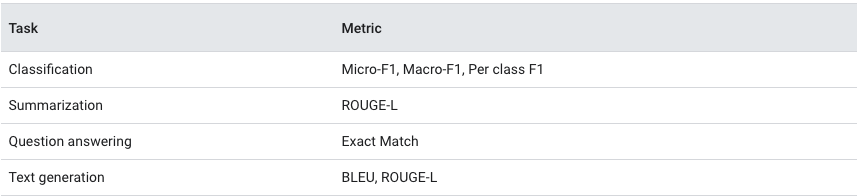

## Getting Started


### Install Vertex AI SDK and other required packages

In [ ]:
!pip install google-cloud-aiplatform --upgrade --user -q "bigframes<1.0.0" rouge-score langchain

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After its restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "your-project-id"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [ ]:
import pandas as pd
from langchain.evaluation import ExactMatchStringEvaluator
from rouge_score import rouge_scorer
from sklearn.metrics import classification_report, f1_score
from vertexai.generative_models import GenerativeModel

### Import model

In [ ]:
generation_model = GenerativeModel("gemini-1.0-pro-001")
generation_config = {"max_output_tokens": 256, "temperature": 0.1}

## Evaluate Text Classification task

In the section below, we will see how to evaluation LLM for classification task.

Evaluation metrics: Micro-F1, Macro-F1, Per class F1




Following is the sample evaluation data which contains text and ground truth values

In [ ]:
eval_data = {
    "text": [
        "i feel a little stunned but can t imagine what the folks who were working in the studio up until this morning are feeling",
        "im updating my blog because i feel shitty",
        "i never make her separate from me because i don t ever want her to feel like i m ashamed with her",
        "i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived",
        "i was feeling a little vain when i did this one",
        "i cant walk into a shop anywhere where i do not feel uncomfortable",
        "i felt anger when at the end of a telephone call",
        "i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia",
        "i like to have the same breathless feeling as a reader eager to see what will happen next",
        "i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer",
    ],
    "ground_truth": [
        "surprise",
        "sadness",
        "sadness",
        "joy",
        "sadness",
        "fear",
        "anger",
        "joy",
        "joy",
        "anger",
    ],
}

In [ ]:
eval_data_df = pd.DataFrame(eval_data)
eval_data_df

Write a function to get text from the evaluation dataset as an input and return output generated by the Gemini model.

In [ ]:
def get_prediction(text):
    prompt = f"""Classify the text into one of the classes bellow: \n[sadness, joy, love, anger, fear, surprise]\n\n
    text:{text} \n
    sentiment:
    """
    response = generation_model.generate_content(contents=prompt).text

    return response

In [ ]:
eval_data_df["prediction"] = eval_data_df["text"].apply(get_prediction)
eval_data_df

Print classification report based on ground truth and model predictions.

In [ ]:
print(classification_report(eval_data_df["ground_truth"], eval_data_df["prediction"]))

Calculate and print per class F1 score.

In [ ]:
# per class F1
print(f1_score(eval_data_df["ground_truth"], eval_data_df["prediction"], average=None))

Calculate and print Macro-F1 score.

In [ ]:
# Macro-F1
f1_score(eval_data_df["ground_truth"], eval_data_df["prediction"], average="macro")

Calculate and print Micro-F1 score.

In [ ]:
# Micro-F1
f1_score(eval_data_df["ground_truth"], eval_data_df["prediction"], average="micro")

# Evaluate Text Summarization task

Write a prompt which contains text you want to summarize.

In [ ]:
prompt = """
Provide a very short, maximum four sentences, summary for the following article:

Our quantum computers work by manipulating qubits in an orchestrated fashion that we call quantum algorithms.
The challenge is that qubits are so sensitive that even stray light can cause calculation errors — and the problem worsens as quantum computers grow.
This has significant consequences, since the best quantum algorithms that we know for running useful applications require the error rates of our qubits to be far lower than we have today.
To bridge this gap, we will need quantum error correction.
Quantum error correction protects information by encoding it across multiple physical qubits to form a “logical qubit,” and is believed to be the only way to produce a large-scale quantum computer with error rates low enough for useful calculations.
Instead of computing on the individual qubits themselves, we will then compute on logical qubits. By encoding larger numbers of physical qubits on our quantum processor into one logical qubit, we hope to reduce the error rates to enable useful quantum algorithms.

Summary:

"""

generation_config = {
    "max_output_tokens": 1024,
    "temperature": 0.1,
    "top_k": 40,
    "top_p": 0.0,
}

candidate = generation_model.generate_content(
    contents=prompt, generation_config=generation_config
).text

print(candidate)

Following is the "reference summary" which will be compaired against the "model generated summary".

In [ ]:
reference = "Quantum computers are sensitive to noise and errors. To bridge this gap, we will need quantum error correction. Quantum error correction protects information by encoding across multiple physical qubits to form a “logical qubit”."

Calculate Rouge-L score

In [ ]:
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)

In [ ]:
scorer.score(reference, candidate)

# Evaluate Question Answering task

Following is a sample dataset which contains the questions and ground truth.

In [ ]:
qa_data = {
    "question": [
        "In a website browser address bar, what does “www” stand for?",
        "Who was the first woman to win a Nobel Prize",
        "What is the name of the Earth’s largest ocean?",
    ],
    "answer_groundtruth": ["World Wide Web", "Marie Curie", "The Pacific Ocean"],
}
qa_data_df = pd.DataFrame(qa_data)
qa_data_df

Write a function to generate answer for each question in the dataset.

In [ ]:
def get_answer(row):
    prompt = f"""Answer the following question as precise as possible.\n\n
            question: {row}
            answer:
              """
    return generation_model.generate_content(
        contents=prompt,
    ).text


qa_data_df["answer_prediction"] = qa_data_df["question"].apply(get_answer)
qa_data_df

In [ ]:
evaluator = ExactMatchStringEvaluator()

Write a function to compare ground truth data and generated answer.

In [ ]:
def get_exact_match(pred, ground_truth):
    score = evaluator.evaluate_strings(prediction=pred, reference=ground_truth)
    return score["score"]

In [ ]:
qa_data_df["exact_match_score"] = qa_data_df.apply(
    lambda row: get_exact_match(row["answer_prediction"], row["answer_groundtruth"]),
    axis=1,
)

print(qa_data_df)